# TigerGraph Graph Data Science Library 101 - Graph Embedding 

This notebook shows the examples of using graph embedding algorithms in TigerGraph Graph Science Library. More detailed explanations of these algorithms can be four in the official documentation 
(https://docs.tigergraph.com/graph-ml/current/node-embeddings/).  

## Step 1: Load Cora graph data

In [1]:
import json
config_file = open ('../config.json', "r")
config = json.load(config_file)
config_file.close()

In [2]:
from pyTigerGraph.datasets import Datasets

dataset = Datasets("Cora")

Downloading:   0%|          | 0/166537 [00:00<?, ?it/s]

In [3]:
from pyTigerGraph import TigerGraphConnection
import json

conn = TigerGraphConnection(
    host=config["host"],
    username=config["username"],
    password=config["password"],
)

In [4]:
conn.ingestDataset(dataset, getToken=config["getToken"])

---- Checking database ----
---- Creating graph ----
The graph Cora is created.
---- Creating schema ----
Using graph 'Cora'
Successfully created schema change jobs: [cora_schema].
Kick off schema change job cora_schema
Doing schema change on graph 'Cora' (current version: 0)
Trying to add local vertex 'Paper' to the graph 'Cora'.
Trying to add local edge 'Cite' to the graph 'Cora'.

Graph Cora updated to new version 1
The job cora_schema completes in 1.707 seconds!
---- Creating loading job ----
Using graph 'Cora'
Successfully created loading jobs: [load_cora_data].
---- Ingesting data ----
Ingested 2708 objects into VERTEX Paper
Ingested 10556 objects into EDGE Cite
---- Cleaning ----
---- Finished ingestion ----


In [5]:
from pyTigerGraph.visualization import drawSchema

drawSchema(conn.getSchema(force=True))

CytoscapeWidget(cytoscape_layout={'name': 'circle', 'animate': True, 'padding': 1}, cytoscape_style=[{'selecto…

## Step 2: Running Louvain Community Detection
We are going to use the pyTigerGraph featurizer to run Louvain community detection on the citation network.

In [6]:
feat = conn.gds.featurizer()

params = {
    "v_type": "Paper",
    "e_type": "Cite",
    "wt_attr": "",
    "max_iter": 10,
    "result_attr": "community_id",
    "file_path": "",
    "print_info": True
}

feat.runAlgorithm("tg_louvain", params = params)

Altering graph schema to save results...
The job add_VERTEX_attr_vRiDrB completes in 1.628 seconds!
Installing and optimizing the queries, it might take a minute...
Queries installed successfully


[{'AllVertexCount': 2708},
 {'InitChangeCount': 0},
 {'VertexFollowedToCommunity': 371},
 {'VertexFollowedToVertex': 114},
 {'VertexAssignedToItself': 0},
 {'FinalCommunityCount': 2280}]

## Step 3: Leveraging pyTigerGraph’s featurizer to run embedding algorithms

pyTIgerGraph provides a full suit of data science capabilities, and in this tutorial, we will showcase how to use featurizer to run a few popular algorithms as an example.

In [7]:
feat.listAlgorithms("Embeddings")

Available algorithms for Embeddings:
  FastRP:
    01. name: tg_fastRP
Call runAlgorithm() with the algorithm name to execute it


### Install and run fastRP algorithm 

Fast Random Projection (FastRP) is a scalable and performant node-embedding algorithm. It generates node embeddings (vectors) of low dimensionality through random projections from the graph’s adjacency matrix (a high-dimensional matrix) to a low-dimensional matrix, significantly reducing the computing power required to process the data. (https://docs.tigergraph.com/graph-ml/current/node-embeddings/fast-random-projection)

In [9]:
params={"v_type": ["Paper"],
        "e_type": ["Cite"],
        "weights": "1,2,4",
        "beta": -0.1,
        "k": 3,
        "reduced_dim": 128,
        "sampling_constant": 3,
        "random_seed": 42,
        "result_attr": "embedding"}

feat.runAlgorithm("tg_fastRP", params=params)

Altering graph schema to save results...
The job add_VERTEX_attr_URVdot completes in 20.237 seconds!
Installing and optimizing the queries, it might take a minute...
Queries installed successfully


[]

In [10]:
df = conn.getVertexDataFrame("Paper")

In [11]:
df.head()

,v_id,id,x,y,train_mask,val_mask,test_mask,community_id,embedding
0,2644,2644,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,False,False,True,406847506,"[0.03616, -0.00431, 0.00443, 0.18269, -0.03913..."
1,2498,2498,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,False,False,True,434110465,"[0, 0.04287, 0.28621, 0.04155, -0.23527, 0.082..."
2,2482,2482,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,False,False,True,434110466,"[-0.22419, -0.16898, -0.0552, -0.16898, -0.285..."
3,2455,2455,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,False,False,True,434110467,"[0, 0.07596, 0, -0.22733, -0.30912, -0.33169, ..."
4,2433,2433,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,False,False,True,386924601,"[0, -0.24595, -0.24595, 0, 0, -0.24595, 0, 0.2..."


In [12]:
import pandas as pd

pd.DataFrame(df['community_id'].value_counts()).value_counts().sort_index()

community_id
1               1925
2                314
3                 29
4                  7
5                  3
12                 1
13                 1
dtype: int64

### Compute intra- and inter-communities similarities for FastRP embeddings using Louvain Communities

In [13]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

cnt = 5
comms_list = ['community_id']

for comm in comms_list:
    print(f"***Community Detection ID: {comm}***\n")
    
    comm_embs = None
    print("Intra-community similarities:\n")

    for i, c_id in enumerate(df[comm].value_counts().head(cnt).index):
        community = df[df[comm] == c_id]
        comm_embs = np.stack(community["embedding"].values)
        similarities = cosine_similarity(comm_embs)
        print(f"Community: {i}")
        print(f"Number of members in community: {len(comm_embs)}")
        print(f"Mean intra-community similarity: {similarities.mean()}")
        print(f"Std. Dev. of intra-community similarity: {np.std(similarities)}")
        print()

    print("Inter-community similarities:\n")

    for i, c_id in enumerate(df[comm].value_counts().head(cnt).index):
        community = df[df[comm] == c_id]
        comm_embs_comp = comm_embs
        comm_embs = np.stack(community["embedding"].values)

        if i >= 1:
            similarities = cosine_similarity(comm_embs_comp, comm_embs)
            print(f"Communities: {i-1}-{i}")
            print(f"Mean inter-community similarity: {similarities.mean()}")
            print(f"Std. Dev. of intra-community similarity: {np.std(similarities)}")
            print()

***Community Detection ID: community_id***

Intra-community similarities:

Community: 0
Number of members in community: 13
Mean intra-community similarity: 0.9925975678341424
Std. Dev. of intra-community similarity: 0.018195031700149116

Community: 1
Number of members in community: 12
Mean intra-community similarity: 0.9969499365383349
Std. Dev. of intra-community similarity: 0.007182530032410187

Community: 2
Number of members in community: 5
Mean intra-community similarity: 0.9983909014097485
Std. Dev. of intra-community similarity: 0.0023456441184528643

Community: 3
Number of members in community: 5
Mean intra-community similarity: 0.9908406007631427
Std. Dev. of intra-community similarity: 0.013352004083949787

Community: 4
Number of members in community: 5
Mean intra-community similarity: 0.9968543647866701
Std. Dev. of intra-community similarity: 0.004585511901915775

Inter-community similarities:

Communities: 0-1
Mean inter-community similarity: -0.12997597623480175
Std. Dev. 

In [14]:
# Grab embeddings for Louvain Communities

c_id0 = df["community_id"].value_counts().head(25).index[0]
c_id1 = df["community_id"].value_counts().head(25).index[1]
c_id2 = df["community_id"].value_counts().head(25).index[2]
c_id3 = df["community_id"].value_counts().head(25).index[3]
c_id4 = df["community_id"].value_counts().head(25).index[4]

community0 = df[df["community_id"] == c_id0]
comm_embs0 = np.stack(community0["embedding"].values)

community1 = df[df["community_id"] == c_id1]
comm_embs1 = np.stack(community1["embedding"].values)

community2 = df[df["community_id"] == c_id2]
comm_embs2 = np.stack(community2["embedding"].values)

community3 = df[df["community_id"] == c_id3]
comm_embs3 = np.stack(community3["embedding"].values)

community4 = df[df["community_id"] == c_id4]
comm_embs4 = np.stack(community4["embedding"].values)

X = np.vstack((comm_embs0, comm_embs1, comm_embs2, comm_embs3, comm_embs4))

y0 = np.ones((comm_embs0.shape[0])) * 0
y1 = np.ones((comm_embs1.shape[0])) * 1
y2 = np.ones((comm_embs2.shape[0])) * 2
y3 = np.ones((comm_embs3.shape[0])) * 3
y4 = np.ones((comm_embs4.shape[0])) * 4
y = np.hstack((y0,y1,y2,y3,y4))

### Plot embeddings in 2D space

In [16]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 366.6 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 1.4 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.5/25.5 MB 4.1 MB/s eta 0:00:0000:0100:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82814 sha256=040e9bd0f192dd00084ca3f84332647de831d8cfe8c3c0775ccf6bb691fe3bdf
  Stored in directory: /Users/feng.shi/Library/Caches/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55496 sha256=8654c74fef7db6a55279a35a429a489339df48b9d5eded9c9b3496c650069670
  Stored in directory: /Users/feng.shi/Library/Caches/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905d

In [17]:
import umap

embd_x = umap.UMAP().fit_transform(X)

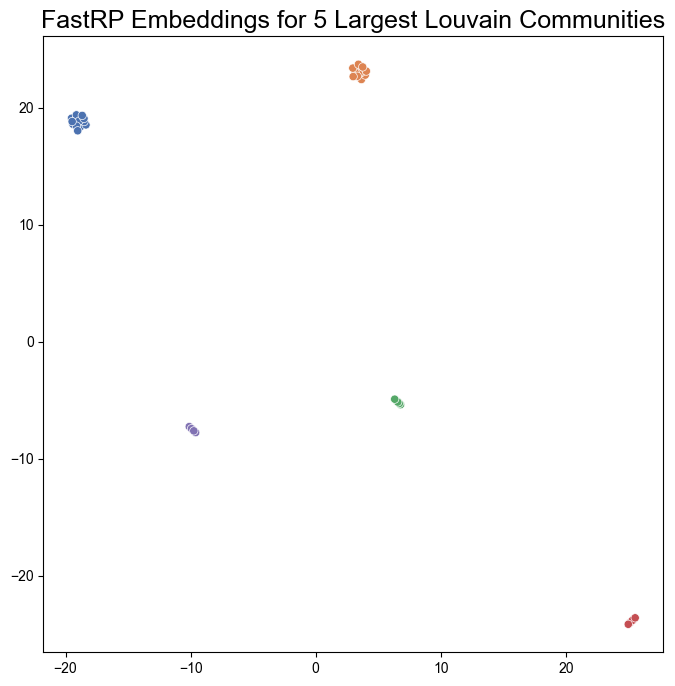

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
sns.set(font_scale=1)

palette = {}
for n, i in enumerate(set([0, 1, 2, 3, 4])):
    palette[i] = f'C{n}'
    
sns.scatterplot(ax=axs, x=embd_x.T[0], y=embd_x.T[1], hue=y, palette=palette)
axs.get_legend().remove()
plt.title("FastRP Embeddings for 5 Largest Louvain Communities", fontsize=18)

plt.show()